# 04_backtesting_and_evaluation.ipynb

# Imports Lib


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Load Data

In [20]:
df = pd.read_csv("../data/processed/sp500_cleaned_model_ready.csv", index_col=0, parse_dates=True)
print(" Dataset loaded:", df.shape)

features = [col for col in df.columns if col not in ["Tomorrow", "Target"]]
target = "Target"

 Dataset loaded: (7872, 45)


# Load a trained model (optional)


In [ ]:
model_path = "../models/best_model_RandomForest.pkl"
model = joblib.load(model_path)
print(f" Loaded trained model from: {model_path}")

 Loaded trained model from: ../models/best_model_RandomForest.pkl


# Define backtest function


In [22]:
def walk_forward_backtest(data, model, features, start=2500, step=250, threshold=0.5):
    """
    Perform a walk-forward backtest.
    - start: number of rows to use as initial training
    - step: how many rows to move forward each iteration
    - threshold: predict class 1 if prob > threshold
    """
    all_predictions = []
    
    for i in range(start, len(data), step):
        # Split train/test by row index
        train = data.iloc[:i]
        test = data.iloc[i:i+step]
        
        # Retrain model on all data up to row i
        re_model = joblib.load(model_path)
        re_model.fit(train[features], train[target])
        
        # Predict probabilities
        probs = re_model.predict_proba(test[features])[:, 1]
        preds = (probs > threshold).astype(int)
        
        # Combine predictions with test set
        temp_df = test.copy()
        temp_df["Prediction"] = preds
        temp_df["Prob_Up"] = probs
        all_predictions.append(temp_df)
    
    return pd.concat(all_predictions)


# Run the backtest


In [23]:
backtest_df = walk_forward_backtest(df, model, features, start=2500, step=250, threshold=0.5)
print("Backtest completed.")
print("Backtest rows:", len(backtest_df))

Backtest completed.
Backtest rows: 5372


# Evaluate performance

In [24]:
precision = precision_score(backtest_df[target], backtest_df["Prediction"], zero_division=0)
recall = recall_score(backtest_df[target], backtest_df["Prediction"], zero_division=0)
f1 = f1_score(backtest_df[target], backtest_df["Prediction"], zero_division=0)

print("\n=== Overall Backtest Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


=== Overall Backtest Metrics ===
Precision: 0.8721
Recall:    0.7441
F1 Score:  0.8030


# Evaluate by year (optional)


In [25]:
backtest_df["Year"] = backtest_df.index.year
yearly_stats = backtest_df.groupby("Year").apply(
    lambda x: pd.Series({
        "Precision": precision_score(x[target], x["Prediction"], zero_division=0),
        "Recall": recall_score(x[target], x["Prediction"], zero_division=0),
        "F1": f1_score(x[target], x["Prediction"], zero_division=0)
    })
)
print("\n=== Yearly Stats ===")
print(yearly_stats)


=== Yearly Stats ===
      Precision    Recall        F1
Year                               
2003   0.882353  0.789474  0.833333
2004   0.883333  0.757143  0.815385
2005   0.878261  0.711268  0.785992
2006   0.906780  0.764286  0.829457
2007   0.906542  0.708029  0.795082
2008   0.765101  0.897638  0.826087
2009   0.908333  0.778571  0.838462
2010   0.914062  0.812500  0.860294
2011   0.902439  0.804348  0.850575
2012   0.866667  0.689394  0.767932
2013   0.976744  0.575342  0.724138
2014   0.881481  0.826389  0.853047
2015   0.872549  0.747899  0.805430
2016   0.846154  0.583333  0.690583
2017   0.917431  0.699301  0.793651
2018   0.783439  0.931818  0.851211
2019   0.908333  0.726667  0.807407
2020   0.914286  0.444444  0.598131
2021   0.916031  0.833333  0.872727
2022   0.745763  0.822430  0.782222
2023   0.839416  0.839416  0.839416
2024   0.908257  0.692308  0.785714
2025   0.764706  0.838710  0.800000


C:\Users\parks\AppData\Local\Temp\ipykernel_12352\3368268988.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_stats = backtest_df.groupby("Year").apply(


# Plot yearly stats


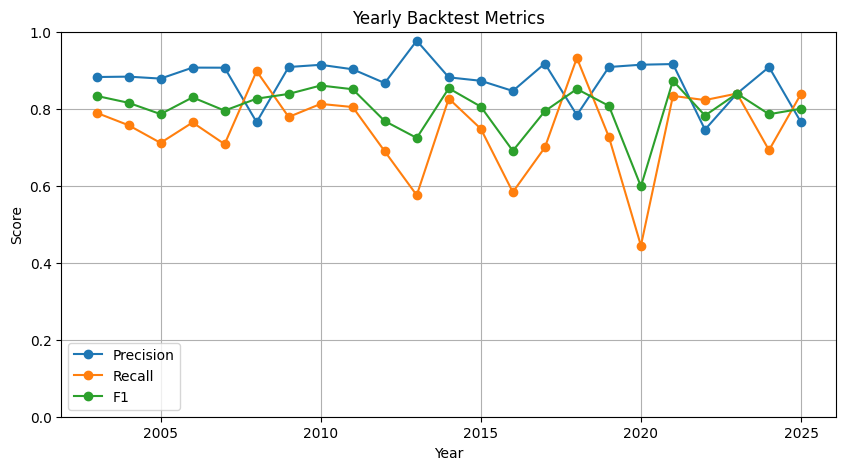

In [26]:
os.makedirs("../reports/images/model", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(yearly_stats.index, yearly_stats["Precision"], marker='o', label="Precision")
plt.plot(yearly_stats.index, yearly_stats["Recall"], marker='o', label="Recall")
plt.plot(yearly_stats.index, yearly_stats["F1"], marker='o', label="F1")
plt.title("Yearly Backtest Metrics")
plt.xlabel("Year")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig("../reports/images/model/backtest_yearly_metrics.png")
plt.show()

# Save backtest predictions (optional)

In [27]:
backtest_df.to_csv("../data/processed/backtest_predictions.csv")
print("\n Backtest predictions saved to ../data/processed/backtest_predictions.csv")

print("\n Backtesting & evaluation complete!")


 Backtest predictions saved to ../data/processed/backtest_predictions.csv

 Backtesting & evaluation complete!
